In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib qt
import glob
from sklearn.preprocessing import StandardScaler

    

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
from skimage.feature import hog
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [3]:
vehicle_folders = ['GTI_Far/','GTI_Left/','GTI_MiddleClose/','GTI_Right/']
none_vehicle_folders = ['GTI/']
car_names = []
no_car_names = []
for vehicle_folder in vehicle_folders:
    images = glob.glob('vehicles/vehicles/'+vehicle_folder+'image*.png')
    car_names.extend(images)
for none_vehicle_folder in none_vehicle_folders:
    images = glob.glob('non-vehicles/non-vehicles/'+none_vehicle_folder+'image*.png')
    no_car_names.extend(images)
images = glob.glob('vehicles/vehicles/KITTI_extracted/*.png')
car_names.extend(images)
images = glob.glob('non-vehicles/non-vehicles/Extras/extra*.png')
no_car_names.extend(images)

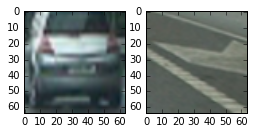

In [6]:
car = mpimg.imread(car_names[0])
not_car = mpimg.imread(no_car_names[0])
plt.figure(figsize=(4,4))
plt.subplot(1, 2, 1)
plt.imshow(car)
plt.subplot(1, 2, 2)
plt.imshow(not_car)

In [9]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()




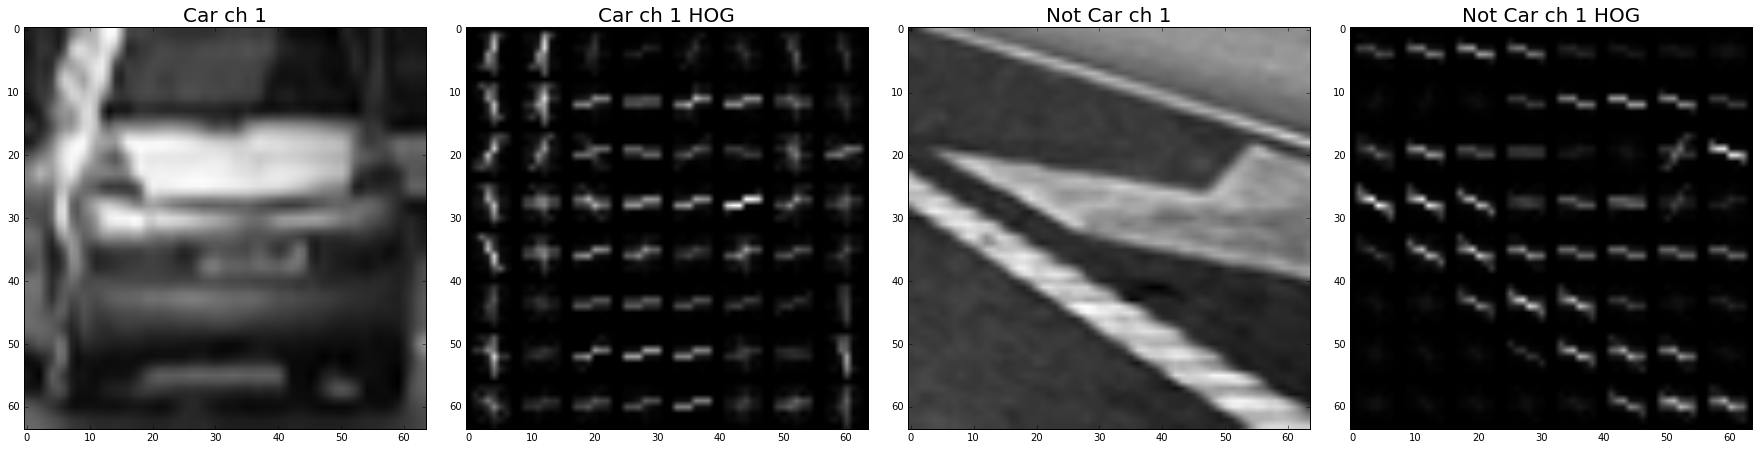

In [12]:
converted_car_image = cv2.cvtColor(car, cv2.COLOR_RGB2YUV)
car_ch1 = converted_car_image[:,:,0]
car_ch2 = converted_car_image[:,:,1]
car_ch3 = converted_car_image[:,:,2]

converted_notcar_image = cv2.cvtColor(not_car, cv2.COLOR_RGB2YUV)
notcar_ch1 = converted_notcar_image[:,:,0]
notcar_ch2 = converted_notcar_image[:,:,1]
notcar_ch3 = converted_notcar_image[:,:,2]

car_hog_feature, car_hog_image = get_hog_features(car_ch1,
                                        orient, pix_per_cell, cell_per_block,
                                        vis=True, feature_vec=True)

notcar_hog_feature, notcar_hog_image = get_hog_features(notcar_ch1,
                                        orient, pix_per_cell, cell_per_block,
                                        vis=True, feature_vec=True)

car_ch1_features = cv2.resize(car_ch1, spatial_size)
# car_ch2_features = cv2.resize(car_ch2, spatial_size)
# car_ch3_features = cv2.resize(car_ch3, spatial_size)
notcar_ch1_features = cv2.resize(notcar_ch1, spatial_size)
# notcar_ch2_features = cv2.resize(notcar_ch2, spatial_size)
# notcar_ch3_features = cv2.resize(notcar_ch3, spatial_size)
def show_images(image1, image2, image3, image4,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3", image4_exp="Image 4"):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1,'gray')
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2,'gray')
    ax2.set_title(image2_exp, fontsize=20)
    ax3.imshow(image3,'gray')
    ax3.set_title(image3_exp, fontsize=20)
    ax4.imshow(image4,'gray')
    ax4.set_title(image4_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
show_images(car_ch1, car_hog_image, notcar_ch1, notcar_hog_image, "Car ch 1", "Car ch 1 HOG", "Not Car ch 1", "Not Car ch 1 HOG")    

In [ ]:
car_features = extract_features(car_names, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(no_car_names, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [6]:
X = np.vstack((car_features,notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

In [7]:
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
print(X_train)

[[  2.70277470e-01   4.69464719e-01   4.74187016e-01 ...,   1.20907361e+01
    1.32717402e+01   1.66130511e+01]
 [  2.71308839e-01   5.09971499e-01   4.98487711e-01 ...,   1.03930602e+02
    0.00000000e+00   9.29025494e+01]
 [  8.70000049e-02   5.02278805e-01   4.97379065e-01 ...,   0.00000000e+00
    0.00000000e+00   8.55639210e-01]
 ..., 
 [  1.29864722e-01   5.03172159e-01   4.57720995e-01 ...,   1.73115205e+00
    4.77335535e-01   6.21012262e-01]
 [  5.78740239e-01   5.66186666e-01   3.52190524e-01 ...,   2.99698526e+01
    2.75305651e+01   8.06188226e+00]
 [  1.55857861e-01   5.07007658e-01   4.93931472e-01 ...,   0.00000000e+00
    0.00000000e+00   1.57729986e+01]]


In [8]:
print(X_train.shape)
from sklearn.preprocessing import StandardScaler
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
print(X_train.shape)
# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

(14208, 11988)
(14208, 11988)


In [9]:
from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(scaled_X_train, y_train)
print('Test Accuracy of SVC = ', svc.score(scaled_X_test, y_test))
print('My SVC predicts: ', svc.predict(X_test[0:10]))
print('For these',10, 'labels: ', y_test[0:10])

Test Accuracy of SVC =  0.983108108108
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  1.  1.  0.  1.]


In [10]:
from sklearn.externals import joblib
dd = {'classifier': svc, 'scaler': X_scaler,'color_space':color_space,
      'orient':orient,'pix_per_cell':pix_per_cell,'cell_per_block':cell_per_block,
      'spatial_size':spatial_size,'hist_bins':hist_bins}
joblib.dump(dd, 'dump_filename')
# data = joblib.load('dump_filename')
# svm = data['classifier']
# scaler = data['scaler']

['dump_filename']

In [14]:
from sklearn.externals import joblib
data = joblib.load('dump_filename')
svc = data['classifier']
X_scaler = data['scaler']
color_space = data['color_space']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data['cell_per_block']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB':
        return img

In [4]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,cells_per_step=3):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
#     cells_per_step = 3  # Instead of overlap, define how many cells to step
    
    
        
        
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1 #how many steps the window to step
#     if ((nxblocks - nblocks_per_window) % cells_per_step)!=0 :
#         nxsteps = nxsteps+1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1 #cells_per_step equals to blocks per step
#     if ((nyblocks - nblocks_per_window) % cells_per_step)!=0 :
#         nyblocks = nyblocks+1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxlists=[]
    scores = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
#             if((xleft+window)>ch1.shape[1]):
#                 xleft = xleft - (xleft+window-ch1.shape[1]) 
#             if((ytop+window)>ch1.shape[0]):
#                 ytop = ytop - (ytop+window-ch1.shape[0])
                
                

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            
            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            a = np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1)
            test_features = X_scaler.transform(a)    
            test_prediction = svc.predict(test_features)
            score = svc.decision_function(test_features)
            

            if (test_prediction == 1):
#                 print('score:',score)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxlists.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                scores.append(score)
                
    return boxlists,scores

In [5]:
#draw box
def draw_box(img,boxlists):
    draw_img = np.copy(img)
    for box in boxlists:
        cv2.rectangle(draw_img,(box[0][0], box[0][1]),(box[1][0],box[1][1]),(0,0,255),6)
    return draw_img
        

In [6]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
def add_score(heatmap, bbox_list,scores):
    # Iterate through list of bboxes
    for i in range(len(bbox_list)):
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[bbox_list[i][0][1]:bbox_list[i][1][1], bbox_list[i][0][0]:bbox_list[i][1][0]] += scores[i]

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes   
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

6
6


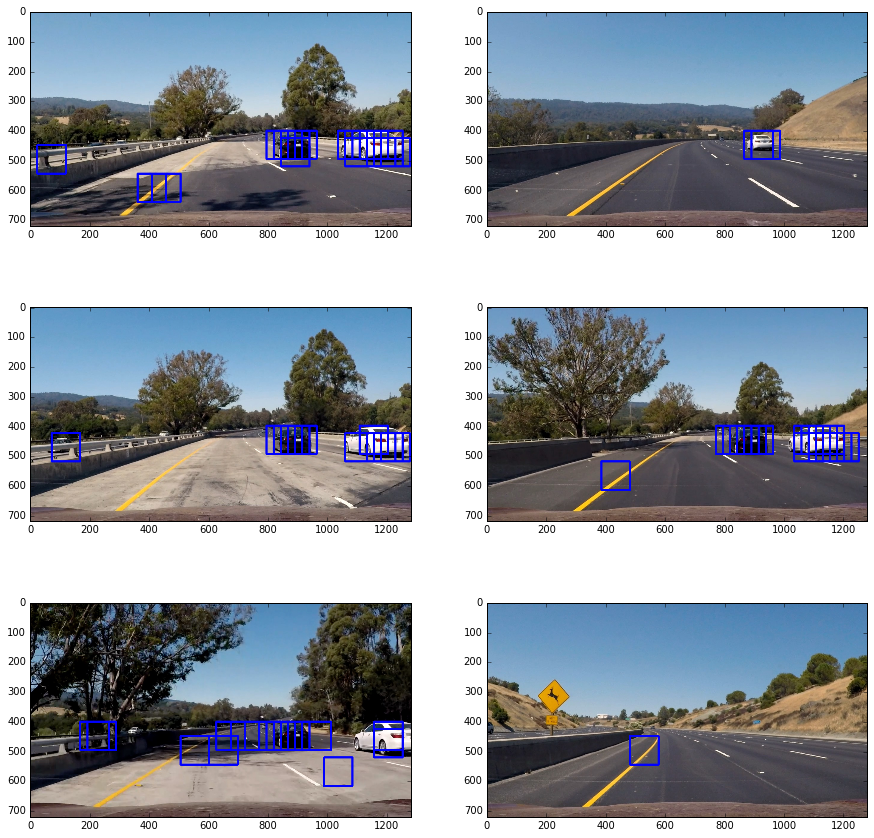

In [24]:

# get attributes of our svc object
#svc = dist_pickle["svc"]
#X_scaler = dist_pickle["scaler"]
# orient = 16
# pix_per_cell = 8
# cell_per_block = 2
# spatial_size = (16, 16)
# hist_bins = 16
ystart = 400
ystop = 656
#scales = [1,1.5,2,2.5,3]
# scales = [1,1.1,1.2,1.5,1.7,2,2.5,3,3.5,4,4.5]
# scales = [[1,2],[1.3,2],[1.4,2],[1.7,2],[1.9,2]]
# scales = [[1.3,2],[1.5,2],[1.7,2]]
scales = [[1.5,2]]
images = glob.glob('test_images/'+'test*.jpg')
plt.figure(figsize=(15,15))
imgs = []
boxlists = []
scores = []
for i in range(len(images)):
    img = mpimg.imread(images[i]) 
    imgs.append(img)
    boxlist = []
    score = []
    for scale in scales:
        boxlist_single ,scores_single= find_cars(img, ystart, ystop, scale[0], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, scale[1])
        boxlist.extend(boxlist_single)
        score.extend(scores_single)
    out_img = draw_box(img,boxlist)
    plt.subplot(3, 2, i+1)
    plt.imshow(out_img)
    boxlists.append(boxlist)
    scores.append(score)
print(len(boxlists))
print(len(scores))

In [25]:
print(len(boxlists[0]))
print(len(scores[0]))

17
17


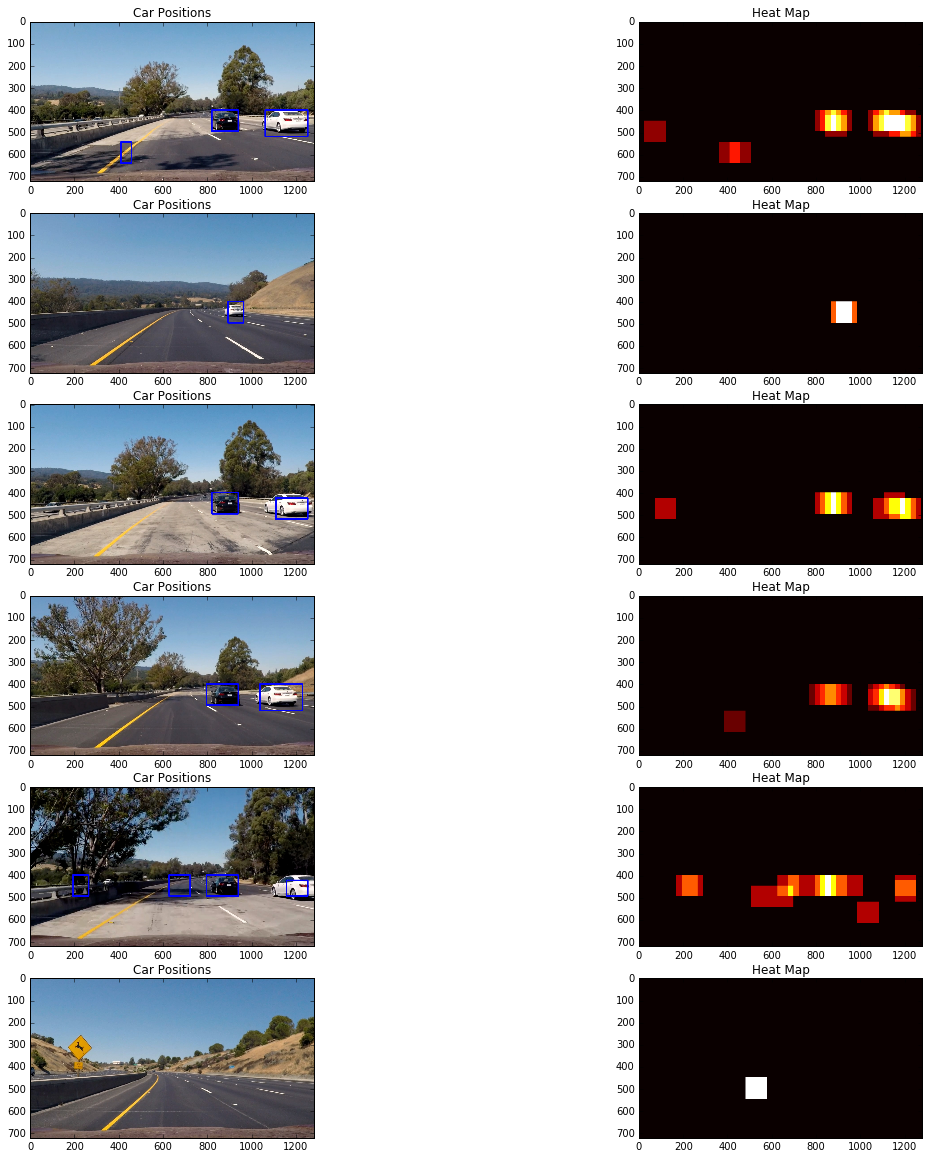

In [26]:
from scipy.ndimage.measurements import label
fig = plt.figure()
plt.figure(figsize=(20,20))
# print(boxlists[1])
for i in range(len(boxlists)):
    heat = np.zeros_like(imgs[i][:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxlists[i])
#     heat = add_score(heat,boxlists[i],scores[i])
    
    plt.subplot(6, 2, i*2+2)
    plt.imshow(heat, cmap='hot')
    plt.title('Heat Map')
    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(imgs[i]), labels)

    plt.subplot(6, 2, i*2+1)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    
#     plt.subplot(6, 2, i*2+2)
#     plt.imshow(heat, cmap='hot')
#     plt.title('Heat Map')

In [27]:
def process_image(img):
    ystart = 400
    ystop = 656
#     scales = [[1,2],[1.3,2],[1.4,2],[1.7,2],[1.9,2]]
    scales = [[1.5,2]]
    boxlist = []
    score = []
    for scale in scales:
        boxlist_single ,scores_single = find_cars(img, ystart, ystop, scale[0], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, scale[1])
        boxlist.extend(boxlist_single)
        score.extend(scores_single)
        
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxlist)
#     heat = add_score(heat,boxlist,score)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img


In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output1 = 'test_video_output.mp4'
clip3 = VideoFileClip('test_video.mp4')
project_clip = clip3.fl_image(process_image)
%time project_clip.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:17<00:00,  2.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 24.2 s, sys: 164 ms, total: 24.4 s
Wall time: 18.1 s
